# World Value Survey Machine Learning #
The purpose of this project is to ...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('data/WV6_Data_CSV.csv')

In [3]:
#How big is the dataframe?
df.shape

(89565, 440)

### Countries ### 
The countries would have a lot of different aspects or perspectives on predicting life satisfaction. I am going to first focus on the United States. At one point I may generalize the code to be able to work for any country code input.

In [4]:
# Remove all countries except the United States
df = df[(df['V2']==840)]
# Remove instances where V23 is null, not answered, or other.
df = df[df['V23'] > 0]

df.reset_index(drop=True)

,V1,V2,V2A,V3,V4,V5,V6,V7,V8,V9,...,VOICE,WEIGHT4B,S001,S007,S018,S019,S021,S024,S025,COW
0,6,840,840,48,1,2,1,2,1,2,...,0.165,1.0,2,-1,0.286738,0.430107,NaN,8406,8402011,2
1,6,840,840,49,1,1,2,3,3,4,...,0.415,1.0,2,-1,0.824373,1.236559,NaN,8406,8402011,2
2,6,840,840,50,1,3,1,3,2,3,...,0.415,1.0,2,-1,1.048387,1.572581,NaN,8406,8402011,2
3,6,840,840,51,1,2,2,2,2,1,...,0.165,1.0,2,-1,0.224014,0.336022,NaN,8406,8402011,2
4,6,840,840,52,1,1,1,2,-2,1,...,0.165,1.0,2,-1,0.129928,0.194892,NaN,8406,8402011,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2211,6,840,840,2359,1,2,2,4,1,3,...,0.415,1.0,2,-1,0.448029,0.672043,NaN,8406,8402011,2
2212,6,840,840,2360,1,2,2,4,1,1,...,0.500,1.0,2,-1,1.129032,1.693548,NaN,8406,8402011,2
2213,6,840,840,2361,1,1,1,4,2,1,...,0.000,1.0,2,-1,0.465950,0.698925,NaN,8406,8402011,2
2214,6,840,840,2362,4,4,4,4,4,4,...,0.580,1.0,2,-1,0.430107,0.645161,NaN,8406,8402011,2


In [5]:
# Check what columns are in the dataset
# for i in df.columns:
#     print(i)

In [6]:
#Check unique values in column to see if it should be deleted
df['V256B'].unique()

array([840091, 840093, 840071, 840055, 840023, 840014, 840032, 840084,
       840034, 840092, 840058, 840035, 840045, 840046, 840064, 840021,
       840063, 840031, 840052, 840022, 840043, 840074, 840088, 840015,
       840056, 840033, 840042, 840086, 840083, 840059, 840011, 840087,
       840072, 840054, 840062, 840041, 840085, 840073, 840082, 840061,
       840051, 840016, 840057, 840047, 840053, 840012, 840044, 840081,
       840013, 840094, 840095], dtype=int64)

### Dropping columns 
I am dropping a lot of columns in the next section of code. This is because a lot of the questions in the survey are only asked at certain countries. The United States isn't asked every single part. When the question isn't asked it leaves me with a column full of the value '-4' which won't do anything for the machine learning methods. That is why they are going to removed to narrow the dataset. 

Also removing more columns in the cell after because I only want to look at the variables that begin with V which are the normally asked survey questions.

In [7]:
#Drop columns not wanted in this analysis
drop_list = ['V2A','V44_ES','V56_NZ','V74B','V125_00','V125_01','V125_02','V125_03','V125_04','V125_06','V125_07',
            'V125_08','V125_09','V125_10','V125_11','V125_12','V125_13','V125_14','V125_15','V125_16','V125_17',
            'V160A','V160B','V160C','V160D','V160E','V160F','V160G','V160H','V160I','V160J','V203A','V215_01','V215_02',
            'V215_03','V215_04','V215_05','V215_06','V215_08','V215_10','V215_11','V215_12','V215_13','V215_14',
             'V215_15','V215_16','V215_17','V215_18','V217_ESMA','V218_ESMA','V219_ESMA','V220_ESMA','V221_ESMA',
             'V222_ESMA','V223_ESMA','V224_ESMA', 'V228_2','V228A','V228B','V228C','V228D','V228E','V228F','V228G',
             'V228H','V228I','V228J','V228K', 'V243_AU', 'V244_AU','V253','V253_CS','V256C']

df.drop(drop_list, axis=1, inplace=True)

In [8]:
#Removing all columns that don't begin with V, and removing Voice
cols = [c for c in df.columns if (c.upper()[:1] == 'V') & (c.upper()!='VOICE')]
df = df[cols]

In [9]:
#Check what columns are now in the dataset
# for i in df.columns:
#     print(i)

In [10]:
df.shape

(2216, 265)

### Target Variable ###
The code below is separating my target variable from the dataset. I will be trying to predict life satisfaction. The actualy wording of the question is "Satisfaction with your life:" and the options range on a scale from 1-10 with 1 being completely dissatisfied and 10 being completely satisfied. 

In [11]:
#Create target variable - Life satisfactions
target = df['V23']

model_df = df.copy(deep=True)
#drop target from predictor data
model_df.drop(['V23'], axis=1, inplace=True)

In [12]:
# Setting the random seed so the results of tests are always the same. Others should be able to replicate them
np.random.seed(12978)
# Create train data and test data
x_train, x_test, y_train, y_test = train_test_split(model_df, target, train_size=0.8)

In [13]:
print("Training data shapes", x_train.shape, y_train.shape)
print("Testing data shapes", x_test.shape, y_test.shape)

Training data shapes (1772, 264) (1772,)
Testing data shapes (444, 264) (444,)


 ### What features are important for the predictor? ### 
When running the above feature importance we get these ten values as being the most important predictors for the random forest model. However, two of them that appeared should be removed as options. V10 is a question about happiness and is far to similar to life satisfaction. V3 is the interview number which would lead our model to have a perfect training set, but not do as well on the test data when using that. I am going to remove both of these variables.  

In [14]:
#drop certain columns we don't want as predictors
model_df.drop(['V10', 'V3'], axis=1, inplace=True)

In [15]:
np.random.seed(12978)
# Create train data and test data
x_train, x_test, y_train, y_test = train_test_split(model_df, target, train_size=0.8)

In [16]:
# Training the Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=8675309)

rf_model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=8675309, verbose=0, warm_start=False)

In [17]:
# a blank dictionary to hold feature_name: feature_importance
feats = {} 
#create dictionary
for feature, importance in zip(x_train.columns, rf_model.feature_importances_):
    feats[feature] = importance #add the key and value

# turn importances to dataframe and sort by importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances = importances.sort_values(by='Gini-importance', ascending=False)

importances.head(10)

,Gini-importance
V59,0.215503
V55,0.150730
V11,0.045485
V56,0.014936
V4,0.012084
V256B,0.007871
V102,0.007740
V249,0.007510
V70,0.007019
V159,0.006893


### What features are important? ###
- V55: How much freedom of choice and control over own life?
- V59: Satisfaction with financial situation of household
- V11: State of health (subjective)
- V56: Do you tihnk most people would try to take advantage of you if they got a chance, or would they try to be fair?
- V58: How many children do you have?
- V4: Important in life: family
- V9: Important in life: religion
- V256B: Region where interview was conducted (2)
- V83: Past two years: Participated in demonstration for environment
- V213: I see myself as part of my local community

### Permutation Importance ###
I found another measure of feature importance for testing which variables are important in predicting variable V23(life satisfaction). This code came from https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

In [18]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rf_model, x_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
top10 = sorted_idx[:10]

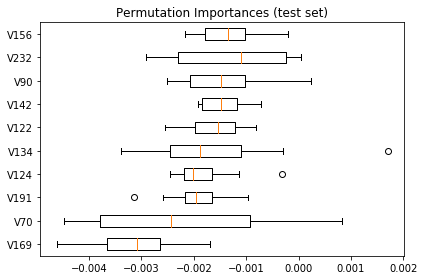

In [19]:
#Graph for Permutation Importance
fig, ax = plt.subplots()
ax.boxplot(result.importances[top10].T, vert=False, labels=x_test.columns[top10])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [25]:
# Narrow down to top ### selectors
keep = ['V55', 'V59', 'V11', 'V56', 'V58', 'V4', 'V9', 'V256B', 'V83', 'V213']
model_df = model_df[keep]

### Random Forest Model ###
Now that I have selected features, I am going to create a random forest model to predict V23

### Logistic Regression Model ### 
I am going to classify V23 into three separate categories, unsatisfied, neutral, and satisfied with life. Then I am going to make a logistic regression model to predict these categories.

Text(0.5, 1.0, 'Histogram of V23')

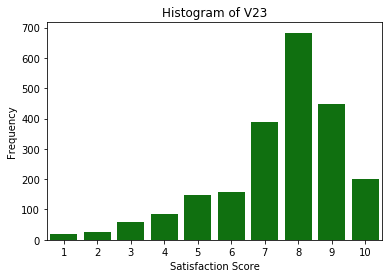

In [22]:
ax = sns.countplot(x="V23", data=df, color='green')
plt.xlabel('Satisfaction Score')
plt.ylabel('Frequency')
plt.title('Histogram of V23')

In [23]:
binned_target = target.copy(deep=True)

binned_target.loc[(binned_target<6)] = 0
binned_target.loc[(binned_target>=6) & (binned_target<=8)] = 1
binned_target.loc[(binned_target>8)] = 2
print(binned_target)

78255    1
78256    1
78257    1
78258    1
78259    2
        ..
80482    2
80483    1
80484    2
80485    0
80486    2
Name: V23, Length: 2216, dtype: int64


Text(0.5, 1.0, 'Histogram of Binned V23')

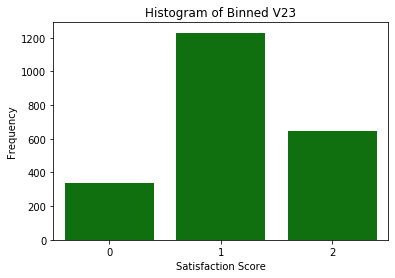

In [24]:
ax = sns.countplot(x=binned_target, data=binned_target, color='green')
plt.xlabel('Satisfaction Score')
plt.ylabel('Frequency')
plt.title('Histogram of Binned V23')

In [27]:
logistic_model = LogisticRegression(random_state=8675309).fit(model_df, binned_target)